In [ ]:
import os
import cv2
import random
import torch
import numpy as np
from PIL import Image
from utils.DiffusionUtils import DiffusionUtils
from utils.TemplateManager import TemplateManager

from ptp.AttentionControls import AttentionStore
from ptp.ptp_utils import text2image_ldm_stable, view_images
from ptp.attn_utils import aggregate_attention, show_cross_attention, show_self_attention_comp

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [2]:
def otsu_thresholding(image: np.ndarray) -> np.ndarray:
    """
    Apply Otsu's thresholding to a color image by converting it to grayscale.
    Parameters: image (np.ndarray): Input color image of shape (H, W, C). 
    Returns: np.ndarray: Binary thresholded image.
    """
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return np.expand_dims(binary_image, axis=2)

def get_image_latent(img_path):
    image = Image.open(img_path).resize((512, 512))
    image = np.expand_dims(image, axis=0)
    image_latent = torch.tensor(DiffusionUtils.image2latent(image[:,:,:,:3]), dtype=torch.float16).to(DiffusionUtils.device)
    return image_latent

In [ ]:
# exp_name = "20250410_0408_hybrid"
# exp_path = f"/home/jack/Code/Research/instree_analysis/experiments/{dataset_name}/{exp_name}"
# cpt_name = "red_teapot"

# origin_img_path = f"{exp_path}/input_concepts/{cpt_name}/v0/"
# img_names = os.listdir(origin_img_path)
# if ".DS_Store" in img_names:
#     img_names.remove(".DS_Store")
# origin_img_path += random.choice(img_names)
# print(f"origin_img_path: {origin_img_path}")

# concept_path = f"{exp_path}/outputs/{cpt_name}/v0/learned_embeds.bin"
# concept_path = f"{exp_path}/outputs/{cpt_name}/v0/v0_seed111/learned_embeds.bin"
# concepts = torch.load(concept_path)
# DiffusionUtils.reset_vocab()
# DiffusionUtils.add_new_vocab('<*>', concepts['<*>'])
# DiffusionUtils.add_new_vocab('<&>', concepts['<&>'])

In [ ]:
paper_concept_path = "/home/jack/Code/Research/instree_main/assets/paper_tokens.bin"
paper_concepts = torch.load(paper_concept_path)
print(paper_concepts.keys())
DiffusionUtils.reset_vocab()

for cpt in paper_concepts.keys():
    DiffusionUtils.add_new_vocab(f"<{cpt}_v1>", paper_concepts[cpt][f"<{cpt}_v1>"])
    DiffusionUtils.add_new_vocab(f"<{cpt}_v2>", paper_concepts[cpt][f"<{cpt}_v2>"])

dict_keys(['cat', 'bear', 'buddha', 'mug', 'teapot', 'round_bird', 'elephant', 'wooden_pot', 'physics_mug', 'red_teapot', 'mug_buildings'])
Vocabulary has been reset.
Current vocab size:  49408
New token added:  <cat_v1>
Current vocab size:  49409
All new tokens:  {'<cat_v1>': 49408}
New token added:  <cat_v2>
Current vocab size:  49410
All new tokens:  {'<cat_v1>': 49408, '<cat_v2>': 49409}
New token added:  <bear_v1>
Current vocab size:  49411
All new tokens:  {'<cat_v1>': 49408, '<cat_v2>': 49409, '<bear_v1>': 49410}
New token added:  <bear_v2>
Current vocab size:  49412
All new tokens:  {'<cat_v1>': 49408, '<cat_v2>': 49409, '<bear_v1>': 49410, '<bear_v2>': 49411}
New token added:  <buddha_v1>
Current vocab size:  49413
All new tokens:  {'<cat_v1>': 49408, '<cat_v2>': 49409, '<bear_v1>': 49410, '<bear_v2>': 49411, '<buddha_v1>': 49412}
New token added:  <buddha_v2>
Current vocab size:  49414
All new tokens:  {'<cat_v1>': 49408, '<cat_v2>': 49409, '<bear_v1>': 49410, '<bear_v2>': 49

In [20]:
cpt_name = 'canada_bear'
cpt_emb_name = 'bear'
origin_img_path = f"/home/jack/Code/Research/instree_analysis/experiment_data/v2/{cpt_name}/v0/"
img_names = os.listdir(origin_img_path)
if ".DS_Store" in img_names:
    img_names.remove(".DS_Store")
origin_img_path += random.choice(img_names)
print(f"origin_img_path: {origin_img_path}")

origin_img_path: /home/jack/Code/Research/instree_analysis/experiment_data/v2/canada_bear/v0/IMG_4229 Large.png


In [35]:
def analyze_attention_map(prompt, image_path=None, mode="cross", seed=0):
    torch.manual_seed(seed)
    controller = AttentionStore()
    latent = None if image_path is None else get_image_latent(image_path)
    step = 25 if latent is None else 1
    
    images, x_t = text2image_ldm_stable(
        DiffusionUtils.pipe, 
        [prompt],
        controller, 
        latent=latent, 
        num_inference_steps=step, guidance_scale=7.5, 
        generator=None, low_resource=False)
    view_images(images)

    result = {}
    if mode == "cross":
        attn_map_8, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, [prompt], controller, res=8, from_where=("mid",))
        attn_map_16, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, [prompt], controller, res=16, from_where=("up", "down"))
        attn_map_32, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, [prompt], controller, res=32, from_where=("up", "down"))
        attn_map_64, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, [prompt], controller, res=64, from_where=("up", "down"))
    elif mode == "self":
        attn_map_8, text = show_self_attention_comp([prompt], controller, res=8, from_where=("mid",))
        attn_map_16, text = show_self_attention_comp([prompt], controller, res=16, from_where=("up", "down"))
        attn_map_32, text = show_self_attention_comp([prompt], controller, res=32, from_where=("up", "down"))
        attn_map_64, text = show_self_attention_comp([prompt], controller, res=64, from_where=("up", "down"))
    else:
        raise ValueError("Invalid mode. Choose either 'cross' or 'self'.")
    
    result["attn_8"] = attn_map_8
    result["attn_16"] = attn_map_16
    result["attn_32"] = attn_map_32
    result["attn_64"] = attn_map_64
    result["text"] = text
    result["image"] = images[0]
    
    controller.reset()
    return result

  0%|          | 0/26 [00:00<?, ?it/s]

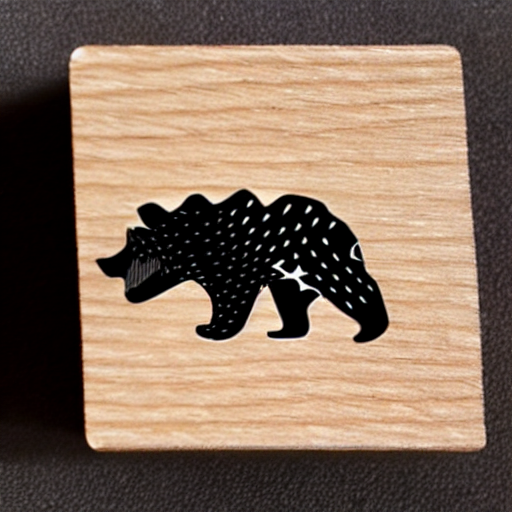

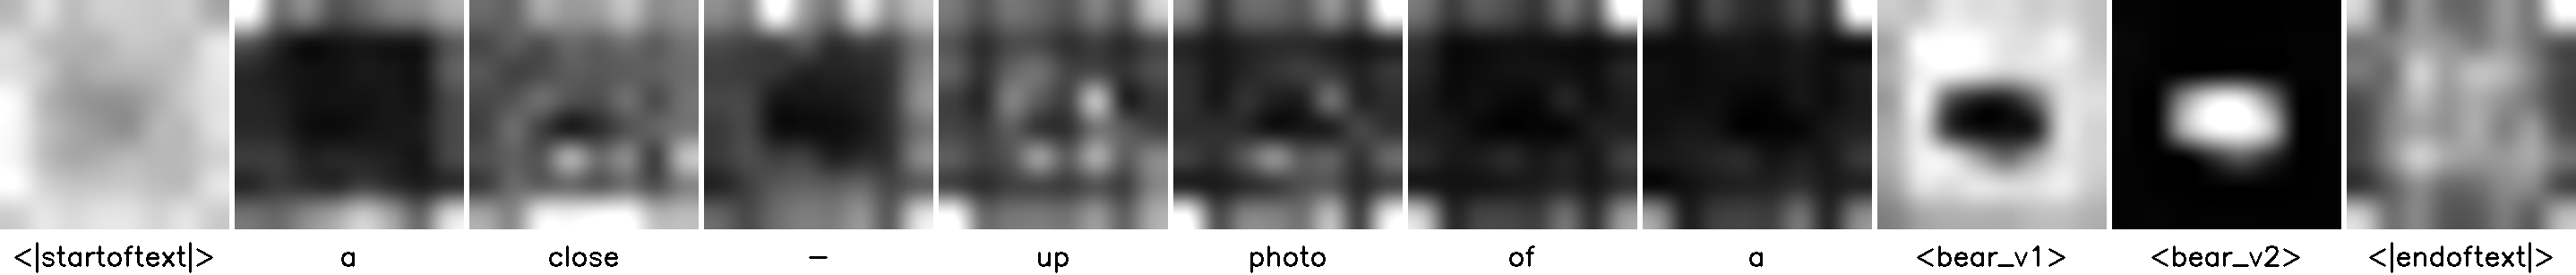

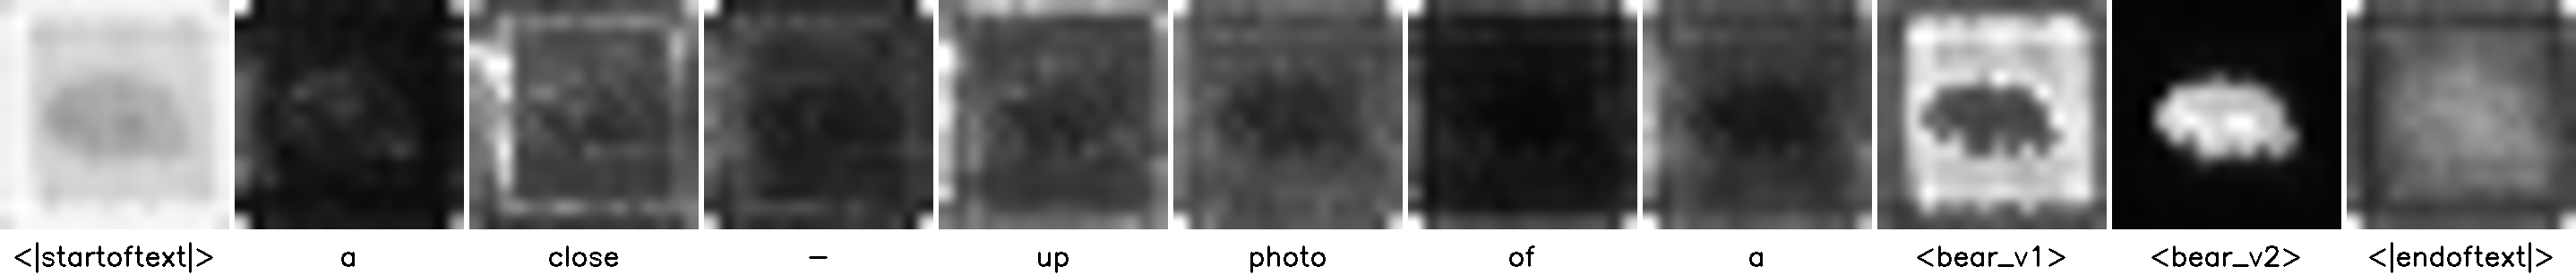

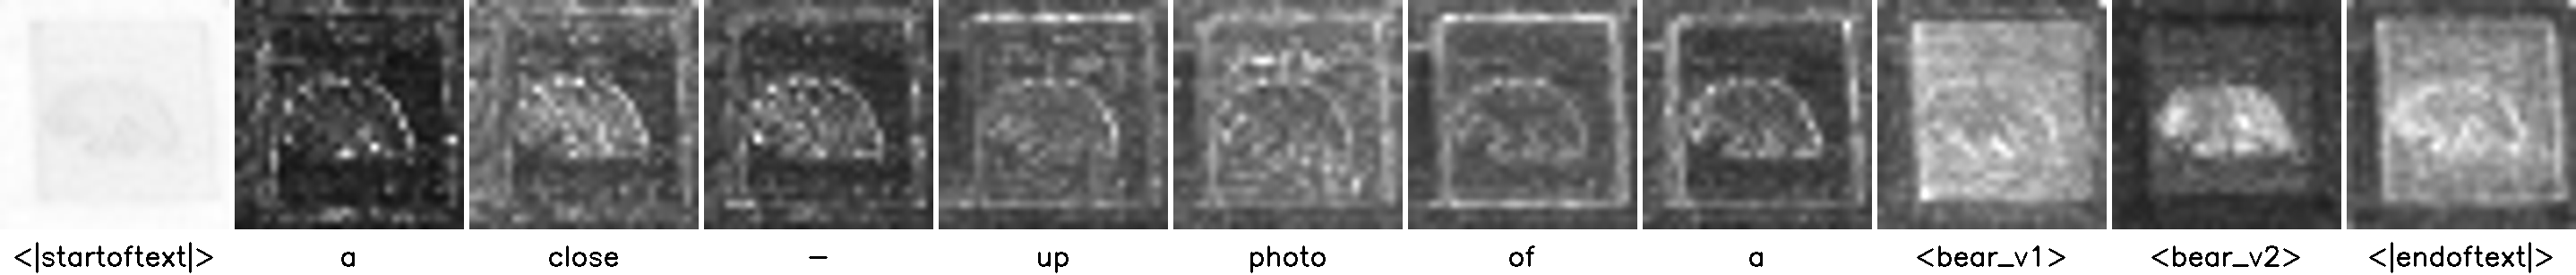

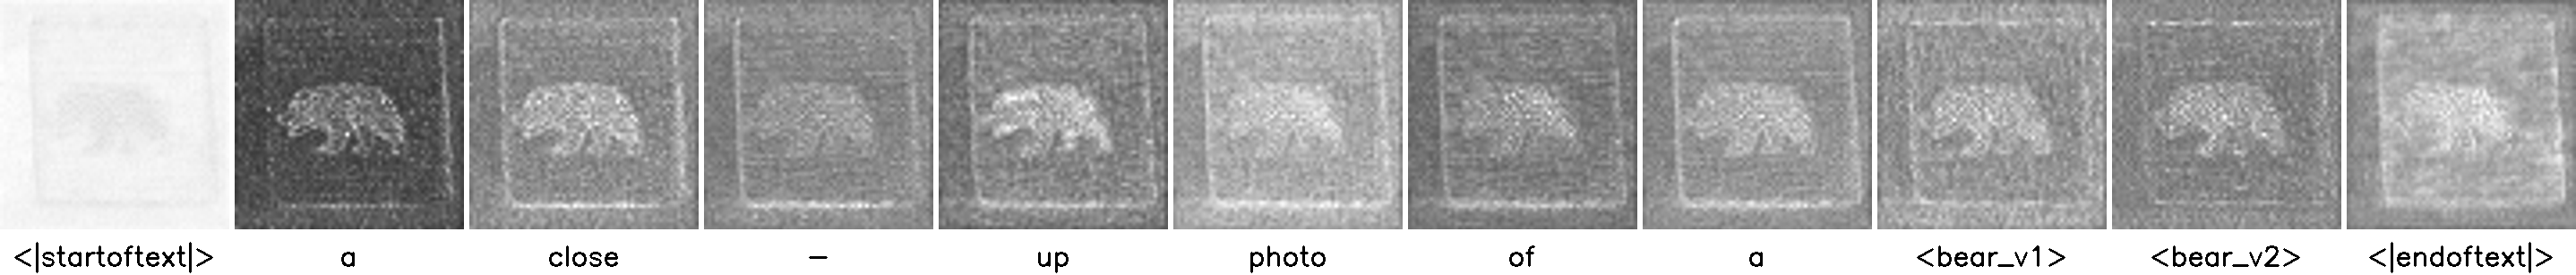

In [36]:
prompt = TemplateManager.get_random_template("IMG").format("<bear_v1> <bear_v2>")
result = analyze_attention_map(prompt)

  0%|          | 0/1 [00:00<?, ?it/s]

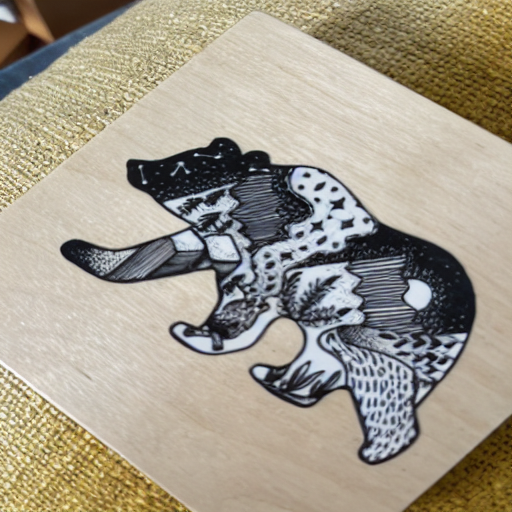

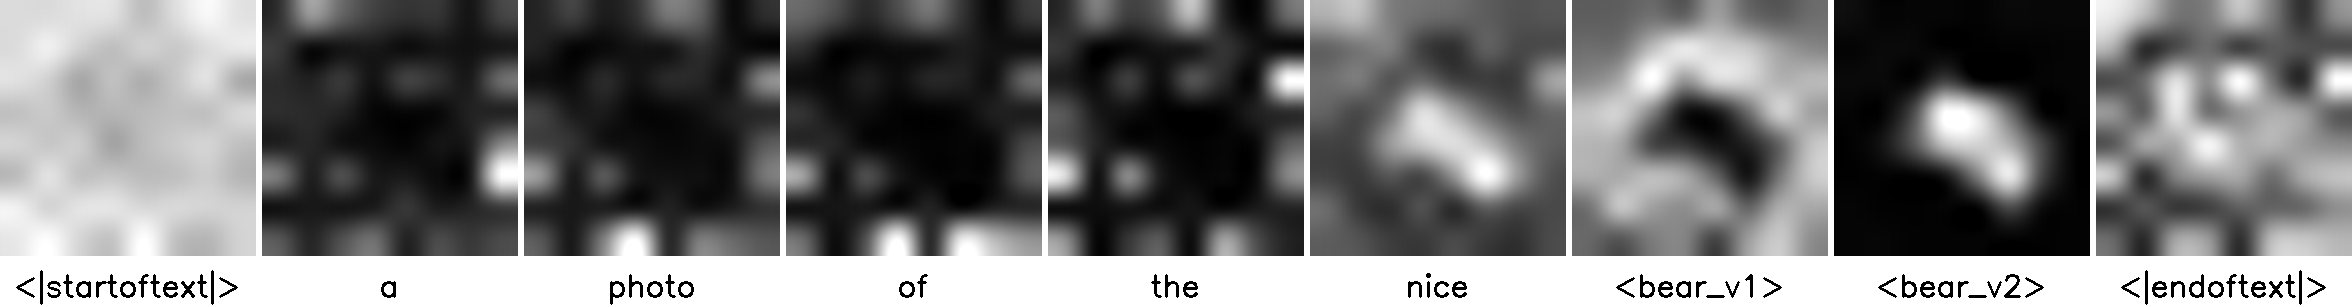

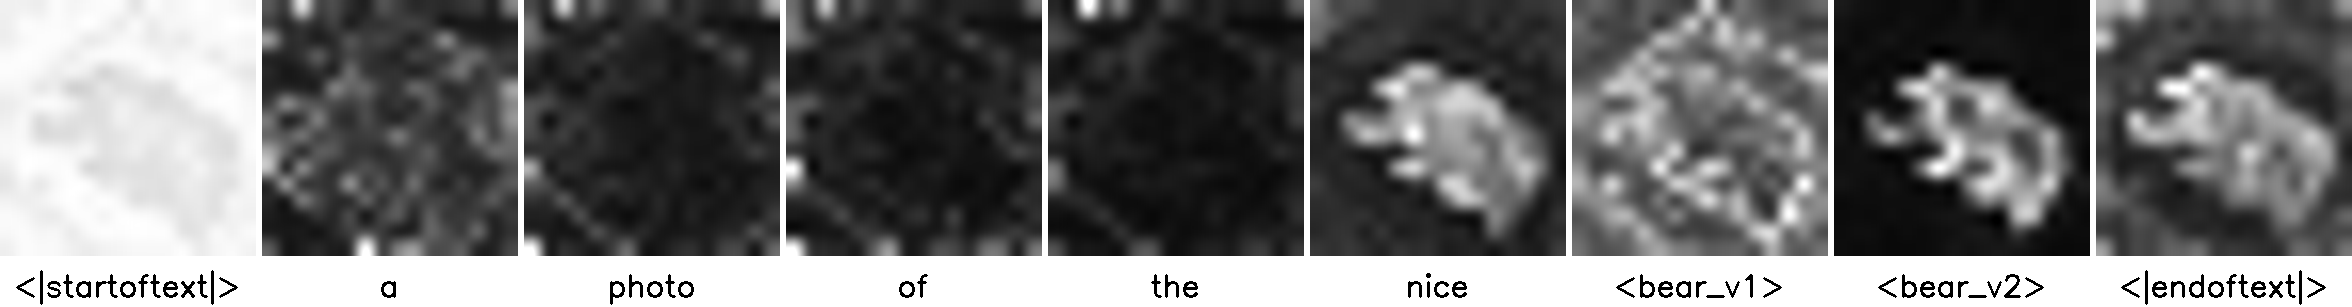

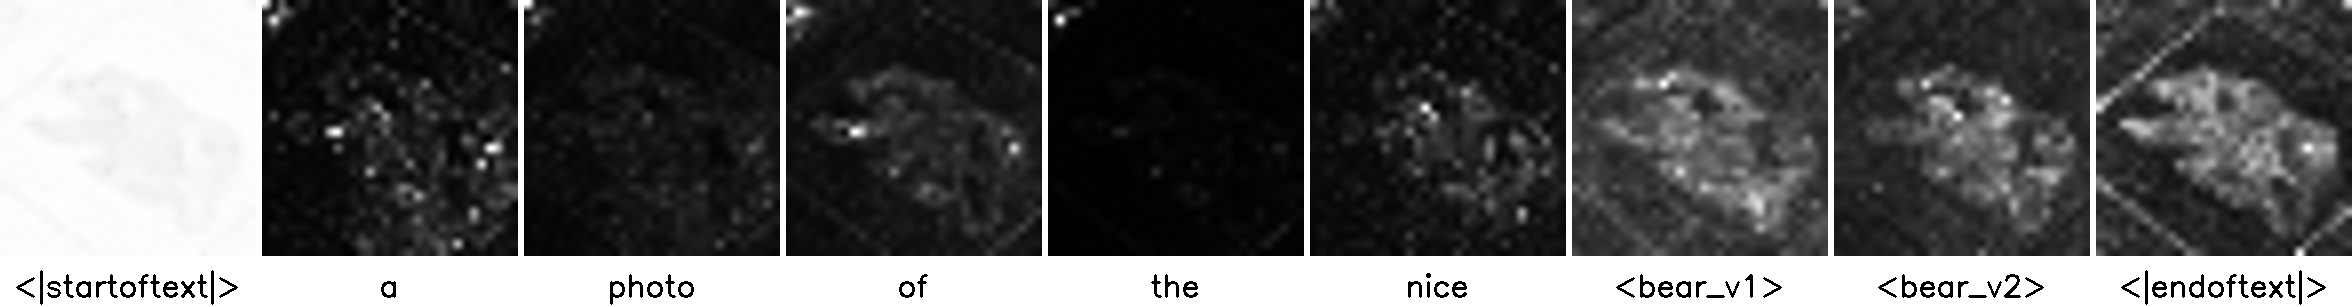

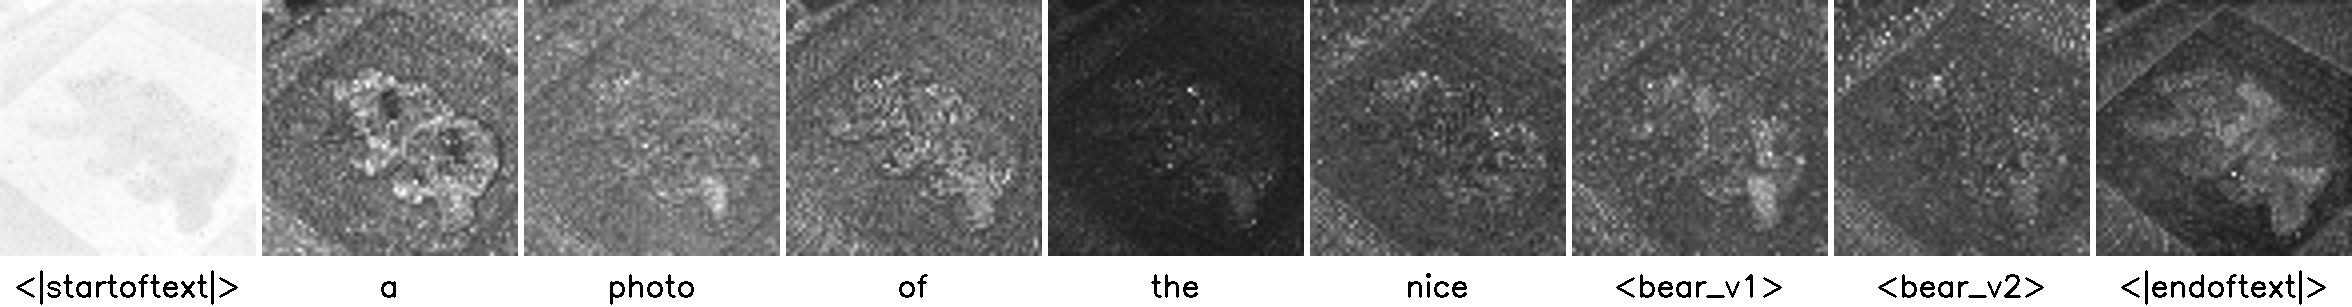

In [37]:
prompt = TemplateManager.get_random_template("IMG").format("<bear_v1> <bear_v2>")
result = analyze_attention_map(prompt, origin_img_path)

['<|startoftext|>', 'a', 'photo', 'of', 'the', 'nice', '<bear_v1>', '<bear_v2>', '<|endoftext|>']


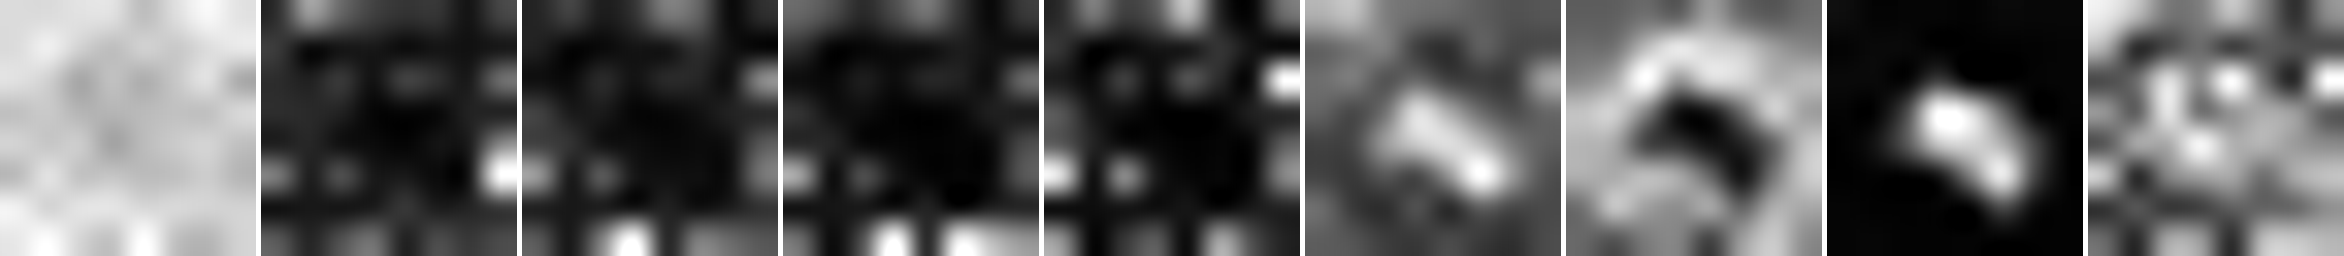

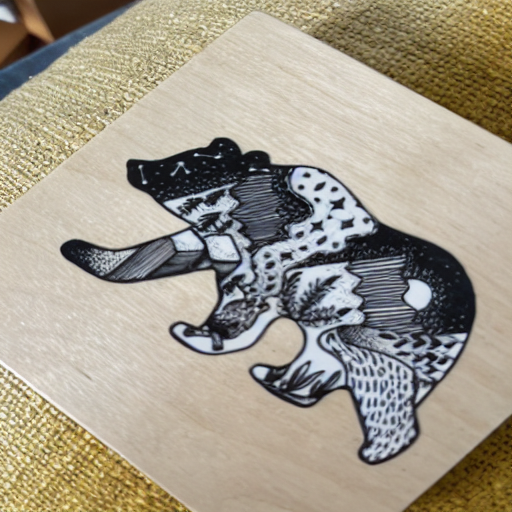

In [39]:
print(result['text'])
view_images(result["attn_8"])
view_images(result["image"])

In [ ]:
text = result['text']
idx_v1 = text.index("<bear_v1>")
idx_v2 = text.index("<bear_v2>")

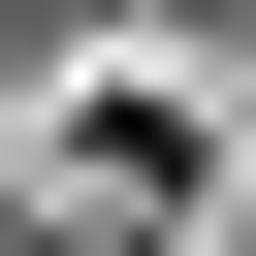

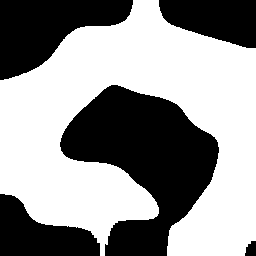

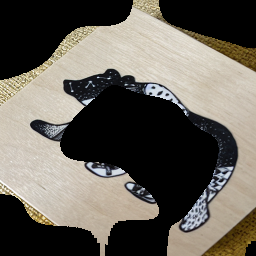

In [45]:
attn_mask = result['attn_8'][idx_v1]
otsu_mask = otsu_thresholding(attn_mask)
resize_origin_img = cv2.resize(result['image'], (256, 256), interpolation=cv2.INTER_CUBIC)

view_images(attn_mask)
view_images(otsu_mask)
view_images(otsu_mask / 255 * resize_origin_img)